In [1]:
#HIDE
try:
    import setup
except:
    pass
from notebook_helper import *
notebook_setup()

from notebook_helper import *
from modules import la
from modules.la_mapping import lower_tier_sandwich, lower_tier_layer, gdf_chart

notebook_setup()
import matplotlib.pyplot as plt

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from scipy.stats.mstats import winsorize

data_year = 2019

# CO2 emissions cluster analysis - variable investigation

The goal of this analysis is to use [BEIS measures of the CO2 emissions](https://data.gov.uk/dataset/723c243d-2f1a-4d27-8b61-cdb93e5b10ff/uk-local-authority-and-regional-carbon-dioxide-emissions-national-statistics-2005-to-2019) under a local authorities control (the subset dataset) to:

1. Determine for each council which other councils are most similar. 
2. Group councils into clusters that explain broadly the problem of their emissions and why they are similar. 

This second attempt uses as dimensions the five grand totals for Industry, Commerical, Domestic, Public Sector, Transport.  

The first attempt used per head emissions to try and isolate the problem of 'big' or dense authorities. However, this caused some problems on the other end, where low densiity areas could end up with very high emissions. 

A different approach by Connected Places catapult used regional GDP to standardize. This if applied to industrial emissions should solve some of the problems and the thinking makes sense that an area is responsible for X GDP, and Y industrial emissions, we're looking for councils with a similar relationship between those two things. Although possibly makes the case for a seperate GDP/area/pop set of clusters.

But does it also logically make sense for others? Should just domestic emissions be scaled per head?

Ultimately, we want councils to be seen as more similar to 

So even if commerical doesn't make sense to distribute per resident head, it is still useful to know the ratio is off. But in these cases is it useful to adjust *at all* for other ones?

Before we can really answer those questions, we need some better understanding of how these different things relate. 

1. What is the relationship between regional GDP and population?
2. Is there a clearer relationship between population or regional GDP and overall emissions?
3. Of different approaches, how much do they actually produce the same results:
    1. All five adjusted per head
    2. Four adjusted per head, Industry per proportion of GDP
    3. Unadjusted except for industry by gdp, domestic per head 
    4. Industry by gdp, domestic per head, rest adjusted by a winsorized version of population
    5. None adjusted


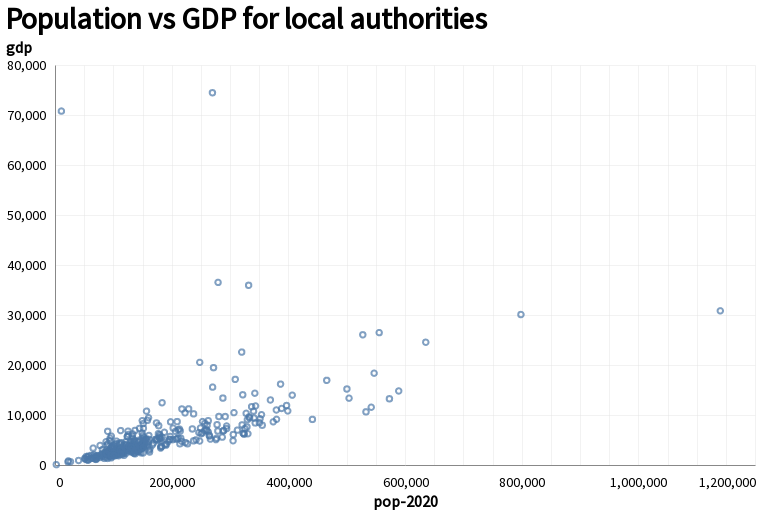

In [2]:

df = la.get_la_df(index=True).la.just_lower_tier()[["pop-2020", "official-name"]].join(gdp)

(Chart(df)
 .mark_point()
 .encode(x="pop-2020", y="gdp")
 .properties(title="Population vs GDP for local authorities")
 .display())


Generally there is a relationship between the two (higher pop, greater GDP, with the relationship breaking down for very large areas), and there being some very productive areas. These are mostly city centers:

In [3]:
df.sort_values("gdp", ascending=False).head(10)

,pop-2020,official-name,gdp
local-authority-code,,,
WSM,2.70e+05,City of Westminster,74449.0
LND,1.09e+04,City of London Corporation,70788.0
CMD,2.80e+05,London Borough of Camden,36525.0
TWH,3.32e+05,London Borough of Tower Hamlets,35937.0
BIR,1.14e+06,Birmingham City Council,30832.0
LDS,7.99e+05,Leeds City Council,30089.0
MAN,5.56e+05,Manchester City Council,26477.0
EDH,5.28e+05,City of Edinburgh Council,26037.0
GLG,6.36e+05,Glasgow City Council,24547.0


# Comparing different approaches

There are different theoretical questions on these different approaches, but how much *do they matter*? Calculating distances for different approaches and comparing the overlap in top 10 for each councils shows how much these different approaches do or do not affect the results.

In [4]:
df = pd.read_excel(Path("data", "2005-19_UK_local_and_regional_CO2_emissions.xlsx"),
                   sheet_name="Subset dataset", header=1)
df = df.loc[df["Year"] == data_year].loc[~df["Code"].isna()]

used_cols = ["Industry Total", "Commercial Total", "Domestic Total", "Public Sector Total", "Transport Total"]

df = df[["Code"] + used_cols]

# transform to  modern councils
df = (df
      .la.code_from_gss("Code", drop=True)
      .la.to_current()
      .la.just_lower_tier())

df = df.la.get_council_info(["pop-2020"]).set_index("local-authority-code")
df = df.join(gdp)
odf = df.copy()
df.head()

,Industry Total,Commercial Total,Domestic Total,Public Sector Total,Transport Total,pop-2020,gdp
local-authority-code,,,,,,,
ABC,440.90,40.71,384.13,9.55,438.66,217232.0,4730.0
ABD,310.28,97.45,482.37,21.37,626.50,260780.0,7961.0
ABE,151.96,155.54,341.95,97.05,326.71,229060.0,11225.0
ADU,18.72,15.36,80.96,4.30,93.63,64187.0,1401.0
AGB,108.17,44.95,161.38,15.53,182.79,85430.0,2234.0


In [5]:

def winsor(series, p=0.05):
    array = winsorize(series, limits = (p, p))
    return pd.Series(array, index=series.index).sort_index()

# functions to make different versions
def all_per_head(df):
    df = df.copy()
    for c in used_cols:
        df[c] = (df[c]/df["pop-2020"])
    df = df[used_cols]
    return df


def four_per_head_industry_per_gdp(df):
    df = df.copy()
    for c in [x for x in used_cols if x != "Industry Total"]:
        df[c] = (df[c]/df["pop-2020"])
    df["Industry Total"] = df["Industry Total"]/df["gdp"]
    df = df[used_cols]
    return df


def only_domestic_and_industry_adjusted(df):
    df = df.copy()

    df["Domestic Total"] = df["Domestic Total"]/df["pop-2020"]
    df["Industry Total"] = df["Industry Total"]/df["gdp"]
    df = df[used_cols]
    return df


def domestic_industry_adjusted_remainder_wpop(df):
    df = df.copy()
    df["wpop"] = winsor(df["pop-2020"])
    cols =  ["Commercial Total", "Public Sector Total", "Transport Total"]
    for c in cols:
        df[c] = (df[c]/df["wpop"])
    df["Domestic Total"] = df["Domestic Total"]/df["pop-2020"]
    df["Industry Total"] = df["Industry Total"]/df["gdp"]
    df = df[used_cols]
    return df

def no_adjustments(df):
    return df.copy()


def get_distance(func):
    return (func(odf)
            .reset_index()
            .space.self_distance("local-authority-code", normalize=True))


files = [no_adjustments, all_per_head, four_per_head_industry_per_gdp, only_domestic_and_industry_adjusted, domestic_industry_adjusted_remainder_wpop]
files = {x.__name__: get_distance(x) for x in files}


In [6]:
df = pd.DataFrame(columns=["measure_a", "measure_b","agreement"])

for label1, df1 in files.items():
    for label2, df2 in files.items():
        jd = df1.space.join_distance(df2)
        agreement = jd.joint_space.agreement(ks=[10])
        top10 = agreement.common.to_map("top_k", "agreement")[10]
        df = df.append({"measure_a":label1, "measure_b":label2, "agreement":top10}, ignore_index=True)

df = df.pivot(index="measure_a", columns="measure_b", values="agreement").style.format(percentage_0dp)

In [7]:
df

measure_b,all_per_head,domestic_industry_adjusted_remainder_wpop,four_per_head_industry_per_gdp,no_adjustments,only_domestic_and_industry_adjusted
measure_a,,,,,
all_per_head,100%,59%,70%,19%,27%
domestic_industry_adjusted_remainder_wpop,59%,100%,72%,21%,36%
four_per_head_industry_per_gdp,70%,72%,100%,17%,33%
no_adjustments,19%,21%,17%,100%,35%
only_domestic_and_industry_adjusted,27%,36%,33%,35%,100%


Annoyingly there is not a lot of similarity, so the theoretical decision actually matters. Hmm. 

In the spirit of providing multiple "ok" options, think the option that adjusts industry by gdp, domestic by population, and the remainder by a lightly winsorized population is probably fine, as long as the cluster approach is good.